In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import scipy.io
!pip install torch torchvision transformers
import torchvision.transforms as transforms
import torch
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
model_name_one = "openai/clip-vit-large-patch14"
clip_model_one = CLIPModel.from_pretrained(model_name_one)
processor_one = CLIPProcessor.from_pretrained(model_name_one)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
import re
bird_class_to_label = {}
bird_dataset_path = '/content/drive/MyDrive/bird_dataset/CUB_200_2011/images'
bird_class_folders = os.listdir(bird_dataset_path)

for label, class_folder in enumerate(bird_class_folders):
    if os.path.isdir(os.path.join(bird_dataset_path, class_folder)):
        bird_class_to_label[class_folder] = label

# Function to clean class names and convert to Title Case with spaces
def clean_class_name(class_name):
    class_name = re.sub(r'[^a-zA-Z\s]', ' ', class_name).strip()  # Remove symbols
    return ' '.join(word.capitalize() for word in class_name.split())  # Convert to Title Case

bird_image = []  # List to hold image filenames and their corresponding class labels

for class_folder in bird_class_folders:
    class_label = bird_class_to_label[class_folder]
    class_folder_path = os.path.join(bird_dataset_path, class_folder)
    image_files = os.listdir(class_folder_path)

    for image_filename in image_files:
        bird_image.append((image_filename, class_folder))

# Convert class names to Title Case with spaces
bird_image_labels = [(image_filename, clean_class_name(class_folder)) for image_filename, class_folder in bird_image]

print(bird_image_labels)


In [ ]:
import json
json_file_path = "/content/drive/MyDrive/bird_dataset/class_descriptions.json"

# Open and load the JSON file
with open(json_file_path, "r") as file:
    class_descriptions = json.load(file)

# Verify the data
print(class_descriptions)

In [ ]:

# Load the CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"

text_features_list = []


# Loop through image labels to generate text prompts and descriptions
for image_filename, class_folder in bird_image_labels:
    # Get the class description from the dictionary
    class_description = class_descriptions[class_folder]
    text_prompt = class_description
    inputs = processor_one(text=text_prompt, return_tensors="pt", padding=True)
    inputs.to(device)

    # Get text features using the CLIP model
    with torch.no_grad():
        text_features = clip_model_one.get_text_features(**inputs.to(clip_model_one.device))
        text_features_list.append(text_features)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model_one.to(device)
bird_class_labels = []
bird_image_labels = []
bird_class_images = {}

for bird_class_folder in bird_class_folders:
    class_folder_path = os.path.join(bird_dataset_path, bird_class_folder)
    class_images = os.listdir(class_folder_path)
    bird_class_images[bird_class_folder] = class_images

image_features_list = []
for bird_class_folder, class_images in bird_class_images.items():
    for image_name in class_images:
        image_path = os.path.join(bird_dataset_path, bird_class_folder, image_name)
        bird_class_labels.append(bird_class_folder)
        bird_image_labels.append(image_path)
        image = Image.open(image_path).convert("RGB")
        image_input = processor_one(images=image, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            image_features = clip_model_one.get_image_features(**image_input)
        image_features_list.append(image_features)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
image_features_tensor = torch.stack(image_features_list)
text_features_tensor = torch.stack(text_features_list)
image_features_tensor = image_features_tensor / image_features_tensor.norm(dim=-1, keepdim=True)
text_features_tensor = text_features_tensor / text_features_tensor.norm(dim=-1, keepdim=True)
image_features_tensor = image_features_tensor.cpu()
text_features_tensor = text_features_tensor.cpu()
image_features_flat = image_features_tensor.view(image_features_tensor.shape[0], -1)
text_features_flat = text_features_tensor.view(text_features_tensor.shape[0], -1)
similarity_matrix = cosine_similarity(image_features_flat, text_features_flat)
predicted_labels = [bird_class_labels[similarity.argmax()] for similarity in similarity_matrix]
correct_predictions = sum(1 for pred, actual in zip(predicted_labels, bird_class_labels) if pred == actual)
accuracy = correct_predictions / len(bird_class_labels) * 100
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 63.44%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
predicted_labels_numeric = [bird_class_to_label[pred] for pred in predicted_labels]
actual_labels_numeric = [bird_class_to_label[actual] for actual in bird_class_labels]
precision = precision_score(actual_labels_numeric, predicted_labels_numeric, average='weighted')
recall = recall_score(actual_labels_numeric, predicted_labels_numeric, average='weighted')
f1 = f1_score(actual_labels_numeric, predicted_labels_numeric, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


Precision: 0.69
Recall: 0.63
F1-score: 0.62


In [ ]:
from sklearn.metrics import classification_report
class_report = classification_report(actual_labels_numeric, predicted_labels_numeric)
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.12      0.19        60
           1       0.93      0.22      0.35        60
           2       0.32      0.78      0.45        58
           3       0.88      0.25      0.39        60
           4       0.24      0.27      0.25        41
           5       0.38      0.11      0.17        53
           6       0.25      0.67      0.36        48
           7       0.43      0.05      0.09        59
           8       0.92      0.98      0.95        60
           9       0.56      0.73      0.64        60
          10       1.00      0.96      0.98        56
          11       0.95      0.95      0.95        60
          12       0.92      0.93      0.93        60
          13       0.56      0.52      0.54        58
          14       1.00      0.88      0.94        58
          15       1.00      0.91      0.95        57
          16       0.97      0.69      0.81        45
    

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(actual_labels_numeric, predicted_labels_numeric)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[ 7  0 49 ...  0  0  0]
 [ 4 13 39 ...  0  0  0]
 [ 3  0 45 ...  0  0  0]
 ...
 [ 0  0  0 ... 57  0  0]
 [ 0  0  0 ...  0  8  0]
 [ 0  0  0 ...  0  0 49]]


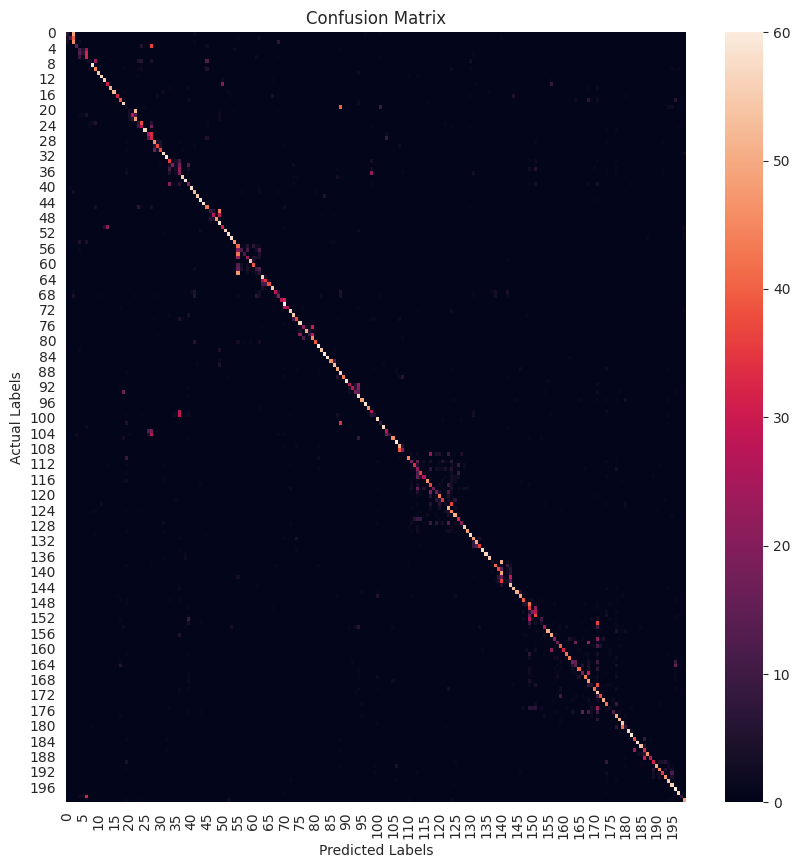

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 10))

sns.heatmap(conf_matrix, fmt="d")

# Set axis labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")

plt.show()


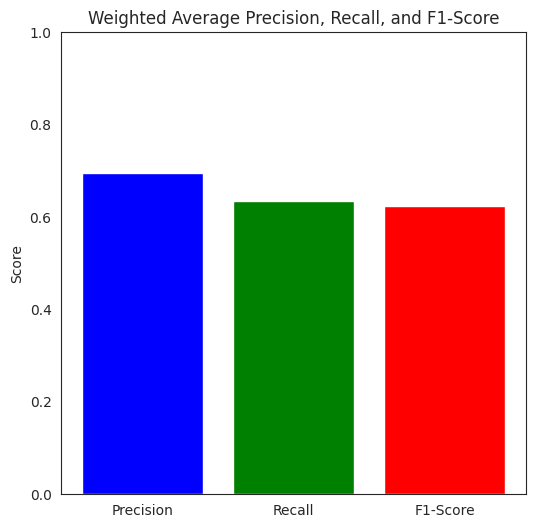

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics._classification import _check_targets

# Compute the classification report
class_report = classification_report(actual_labels_numeric, predicted_labels_numeric, output_dict=True)

# Extract precision, recall, and f1-score for each class
precision_dict = class_report['weighted avg']
recall_dict = class_report['weighted avg']
f1_dict = class_report['weighted avg']

# Create a bar chart
fig, ax = plt.subplots(figsize=(6, 6))
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision_dict['precision'], recall_dict['recall'], f1_dict['f1-score']]

plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.ylabel('Score')
plt.title('Weighted Average Precision, Recall, and F1-Score')
plt.ylim(0, 1)  # Set the y-axis limit to [0, 1] for precision, recall, and F1-score
plt.show()
